# Assignment B
---

1) Downloaded 50 images of dogs which can be found [here](https://github.com/genigarus/EVA4/tree/master/S12/AssignmentB/dogs). 

2) Annotated bounding boxes around the dogs using VIA.

3) JSON file containing the annotations can be found [here](https://github.com/genigarus/EVA4/blob/master/S12/AssignmentB/dog_annotations.json). 

4) Described the contents of this annoation JSON file in FULL details [here](). 


## 5) Finding out the best total numbers of clusters for this dog dataset.

In [1]:
## Connecting google drive to colab

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.19-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.19-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.19-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

### Imports
---

In [3]:
import os
import json
import codecs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
default_path = 'drive/EVA4/Session12/AssignmentB/'
data_json_file = "dog_annotations.json"

### Helper Functions
---

In [0]:
def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

def iou_sk(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (1, 2) denoting cluster to which it belongs
    :return: float iou
    """
    x = np.minimum(clusters[0], box[0])
    y = np.minimum(clusters[1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[0] * clusters[1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes_with_labels, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    #return np.mean([iou(boxes_with_labels['bbox'][i], clusters[boxes_with_labels['cluster_centroid'][i]]) for i in range(boxes_with_labels['bbox'].shape[0])])
    return np.mean([np.max(iou(boxes_with_labels['bbox'][i], clusters)) for i in range(boxes_with_labels['bbox'].shape[0])])

def avg_iou_sk(boxes_with_labels, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([iou_sk(boxes_with_labels['bbox'][i], clusters[boxes_with_labels['cluster_centroid'][i]]) for i in range(boxes_with_labels['bbox'].shape[0])])
    #return np.mean([np.max(iou(boxes_with_labels['bbox'][i], clusters)) for i in range(boxes_with_labels['bbox'].shape[0])])

def kmeans_clustering(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

def iterate_kmeans(num_iter, X, bbox_X, is_sklearn=True):
  # find optimal no. of K
  wcss = []
  m_iou = []
  if is_sklearn:
    for i in range(1,num_iter):
      kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=0)
      kmeans.fit(X)
      clusters = kmeans.cluster_centers_
      boxes_with_labels = {'bbox': bbox_X, 'cluster_centroid': kmeans.labels_}
      m_iou.append(avg_iou_sk(boxes_with_labels, clusters))
      wcss.append(kmeans.inertia_)
  else:
    for i in range(1,num_iter):
      clusters = kmeans_clustering(X, i)
      boxes_with_labels = {'bbox': bbox_X}
      m_iou.append(avg_iou(boxes_with_labels, clusters))
  
  return m_iou, wcss

def visualize(xs, ys, xlabel="Number of Clusters", ylabel="Mean IoU", title="Mean IoU vs Number of Clusters"):
  plt.figure(figsize=(20,10))
  # 'bo-' means blue color, round points, solid lines
  plt.plot(xs, ys,'bo-')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  
  # zip joins x and y coordinates in pairs
  for x,y in zip(xs,ys):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
  plt.show()

def create_clusters(X, n_clusters, init='k-means++', n_init=10, random_state=0, is_sklearn=True):
  # create clusters
  if is_sklearn:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=0)
    y_means = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_
  else:
    centroids = kmeans_clustering(X, n_clusters)
    y_means = [np.max(iou(X[i], centroids)) for i in range(X.shape[0])]

  return y_means, centroids

def plot_clusters(X, y_means, centroids, n_clusters):
  plt.figure(figsize=(20,10))
  # plot clusters
  colors = matplotlib.cm.rainbow(np.linspace(0, 1, n_clusters))
  for index in range(n_clusters):
    label = 'Cluster '+str(index)
    color = colors[index].reshape(1,-1)
    plt.scatter(X[y_means==index,0], X[y_means==index,1], s=100, c=color, label=label)
  plt.scatter(centroids[:,0], centroids[:,1], s=150, c='yellow', edgecolors='black', label='Centroid')
  plt.title("Clusters")
  plt.xlabel('Width')
  plt.ylabel('Height')
  plt.legend()
  plt.show()



### Load JSON annotation file data as Pandas Dataframe
---

**Loaded json data file**

In [0]:
# Loaded json data file
json_data = json.load(codecs.open(default_path+data_json_file, 'r', 'utf-8-sig'))

**Format Data with image name, image height, image width, bounding box center, bounding box height and width**

In [0]:
data_list = []
for _, val in json_data.items():
  bbox_attrib = ("x", "y", "width", "height")
  file_attributes = val["file_attributes"]
  index = 1
  for region in val["regions"]:
    region_attributes = region["region_attributes"]
    bbox_attributes = {item: region["shape_attributes"][item] for item in region["shape_attributes"] if item in bbox_attrib}
    if len(val["regions"]) > 1:
      data_list.append({"name": val["filename"].split(".")[0]+"_"+index+val["filename"].split(".")[1], **file_attributes, **region_attributes, **bbox_attributes})
      index += 1
    else:
      data_list.append({"name": val["filename"], **file_attributes, **region_attributes, **bbox_attributes})

**Convert formatted data as pandas dataframe and preprocess it**

In [0]:
dataset = pd.DataFrame(data_list)
# preprocessing
dataset = dataset.astype({'image_width': 'int64', 'image_height': 'int64'})

# convert image to square size by adding padding
dataset['sq_image_width'] = dataset.apply(lambda row: max(row['image_width'], row['image_height']), axis=1)
dataset['sq_image_height'] = dataset.apply(lambda row: max(row['image_width'], row['image_height']), axis=1)
# pad_img()

# normalize
dataset['n_image_width'] = 1.0
dataset['n_image_height'] = 1.0
dataset['n_x'] = dataset.apply(lambda row: row['x']/row['sq_image_width'], axis=1)
dataset['n_y'] = dataset.apply(lambda row: row['y']/row['sq_image_height'], axis=1)
dataset['n_width'] = dataset.apply(lambda row: row['width']/row['sq_image_width'], axis=1)
dataset['n_height'] = dataset.apply(lambda row: row['height']/row['sq_image_height'], axis=1)
dataset['n_width_log'] = dataset.apply(lambda row: np.log(row['n_width']), axis=1)
dataset['n_height_log'] = dataset.apply(lambda row: np.log(row['n_height']), axis=1)

**Dataset will look like this**

In [9]:
dataset.head()

,name,image_width,image_height,class,x,y,width,height,sq_image_width,sq_image_height,n_image_width,n_image_height,n_x,n_y,n_width,n_height,n_width_log,n_height_log
0,dog1.jpg,1280,853,dog,626,144,502,618,1280,1280,1.0,1.0,0.489063,0.112500,0.392188,0.482812,-0.936015,-0.728127
1,dog2.jpg,3700,2577,dog,1090,406,2006,2162,3700,3700,1.0,1.0,0.294595,0.109730,0.542162,0.584324,-0.612190,-0.537299
2,dog3.jpg,640,637,dog,72,63,464,553,640,640,1.0,1.0,0.112500,0.098437,0.725000,0.864062,-0.321584,-0.146110
3,dog4.jpg,680,384,dog,337,71,243,200,680,680,1.0,1.0,0.495588,0.104412,0.357353,0.294118,-1.029031,-1.223775
4,dog5.jpg,634,423,dog,176,37,312,356,634,634,1.0,1.0,0.277603,0.058360,0.492114,0.561514,-0.709046,-0.577118


**Visualization of the normalized bounding box height and width points taking origin as bottom left**
---

We can see that based on the density of points minimum of 3 clusters are approximately needed. Lets delve further.

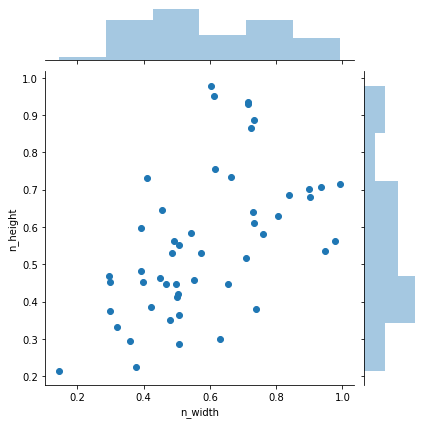

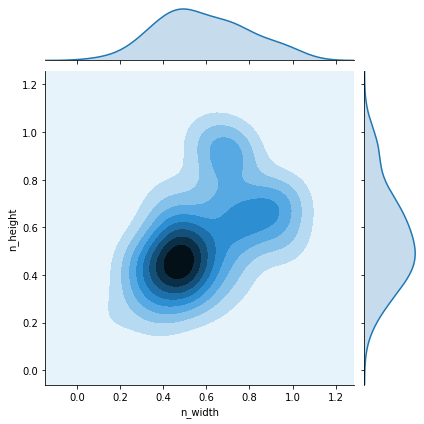

In [10]:
#Joint Plot of b_w and b_h
sns.jointplot(x="n_width", y="n_height", data=dataset)
sns.jointplot(x="n_width", y="n_height", data=dataset, kind='kde')

**The density graph of log of bounding box normalized width and height give a better demarkation of clusters as compared to normalized ones. Here, we can see a clear 2 cluster zone.**

Lets go deeper.

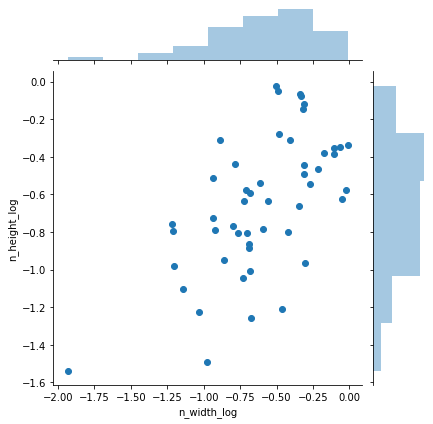

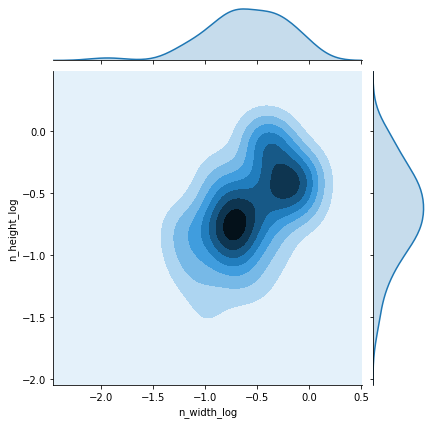

In [0]:
sns.jointplot(x="n_width_log", y="n_height_log", data=dataset)
sns.jointplot(x="n_width_log", y="n_height_log", data=dataset, kind='kde')

## Finding Best Clusters
---

**From the dataset, I selected normalized height and width of bounding boxes as *X* along with their normalized ones as *X1*. These values will be used by K-means clustering for finding out the clusters.**

In [0]:
# importing dataset
X = dataset.loc[:,['n_width', 'n_height']].values
X1 = dataset.loc[:,['n_width_log', 'n_height_log']].values

### Finding optimal "K"
---

1) K-means clustering was run with 25 consecutive values starting from 1.

2) For each value, the clusters found were used to calculate the average of max IoU of cluster centroid with respect to the corresponding normalized log and non-log bounding box dimension.

3) **wcss** contains the all the mean IoU for normalized bounding box dimension.

4) **wcss1** contains the all the mean IoU for log of normalized bounding box dimension.

In [0]:
num_iter = 25
m_iou, wcss = iterate_kmeans(num_iter, X, X)
m_iou1, wcss1 = iterate_kmeans(num_iter, X1, X)

### Plotting mean IoU against number of clusters
---

For normalized bounding box dimension **wcss**, we see diminishing increase after **2nd point**.

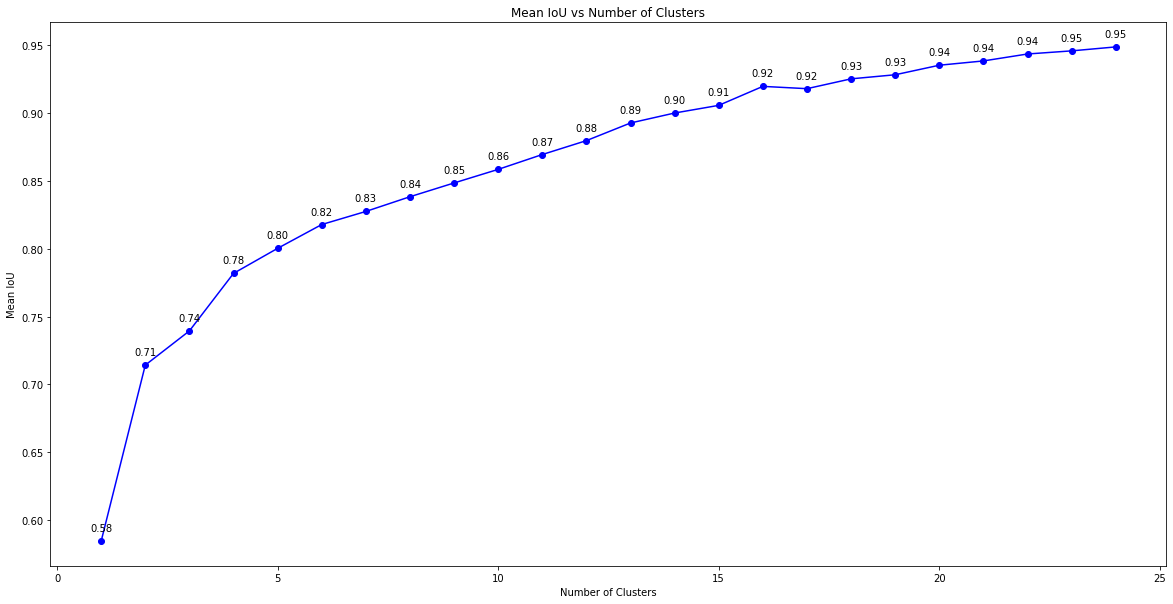

In [37]:
# Create plot
xs, ys = range(1,num_iter), m_iou
visualize(xs, ys)

#### Elbow method
---

The elbow method is to identify the number of clusters based on the assumption that the optimal number of clusters must produce small inertia, or total intra-cluster variation.

We should choose a number of clusters so that adding another cluster doesn’t improve much.

From below graph, we can see that the intra-cluster variation doesn't improve much after **2 clusters**.

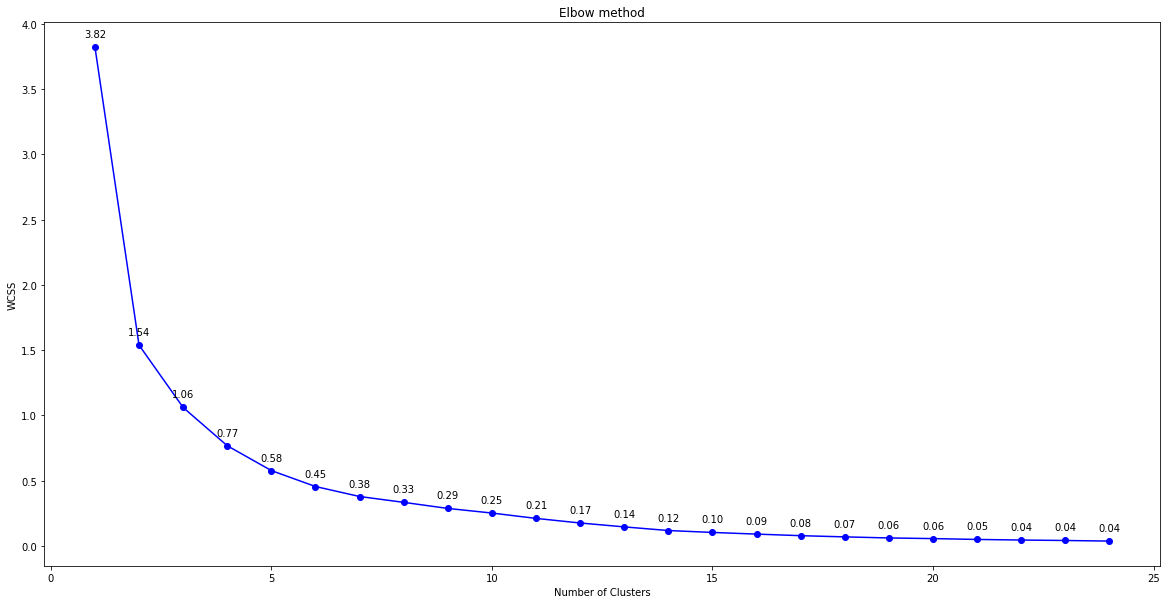

In [38]:
# Create plot
xs, ys = range(1,num_iter), wcss
visualize(xs, ys, ylabel="WCSS", title="Elbow method")

#### Silhouette Analysis
---

Silhouette score measures how well an observation is clustered and it estimates the average distance between clusters. It wants to find the optimal number of clusters that produce a subdivision of the dataset to dense blocks that are well separated from each other.

The value will be between -1 and 1, whereas a value near 0 indicates overlapping clusters. Negative values generally indicate that an observation has been assigned to the wrong cluster.

For n_clusters = 2 The average silhouette_score is : 0.5154123069701414
For n_clusters = 3 The average silhouette_score is : 0.5055411502000582
For n_clusters = 4 The average silhouette_score is : 0.41766065930580076
For n_clusters = 5 The average silhouette_score is : 0.41110662055645003
For n_clusters = 6 The average silhouette_score is : 0.4160136966109696
For n_clusters = 7 The average silhouette_score is : 0.419554639970793
For n_clusters = 8 The average silhouette_score is : 0.41877744271893425
For n_clusters = 9 The average silhouette_score is : 0.4147524307315381


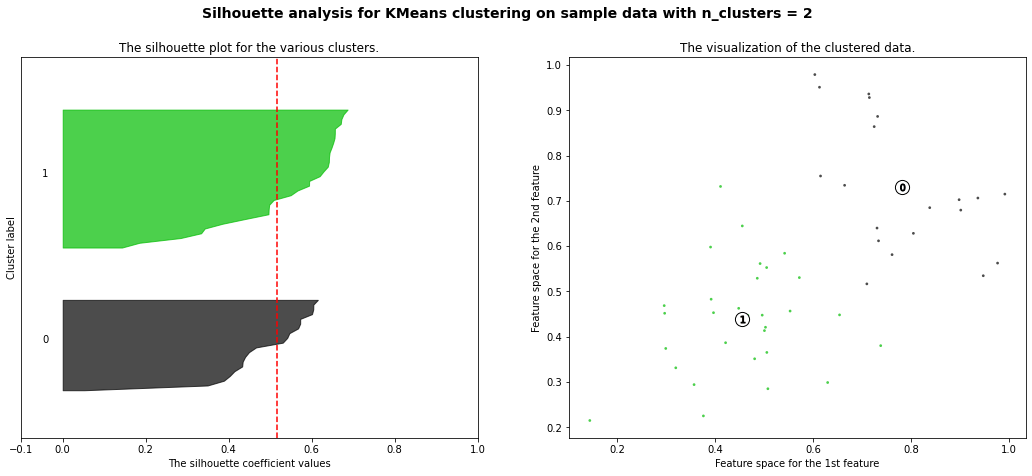

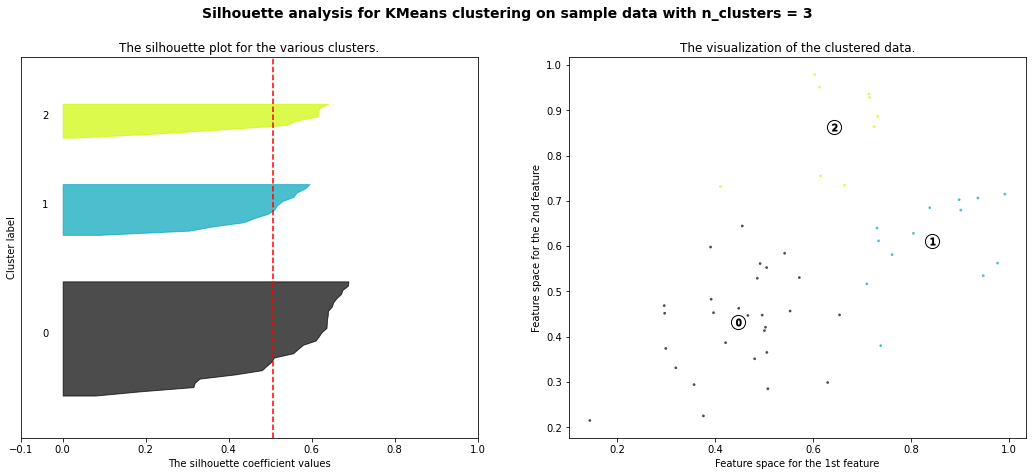

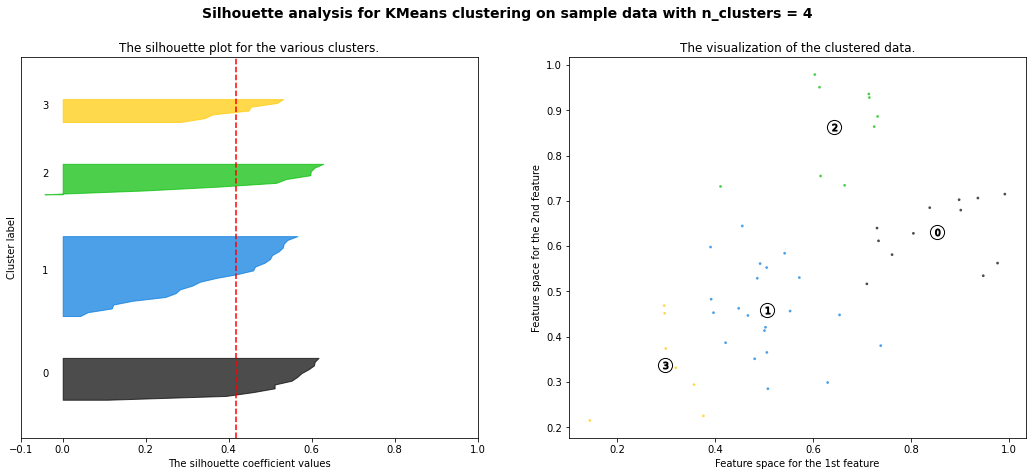

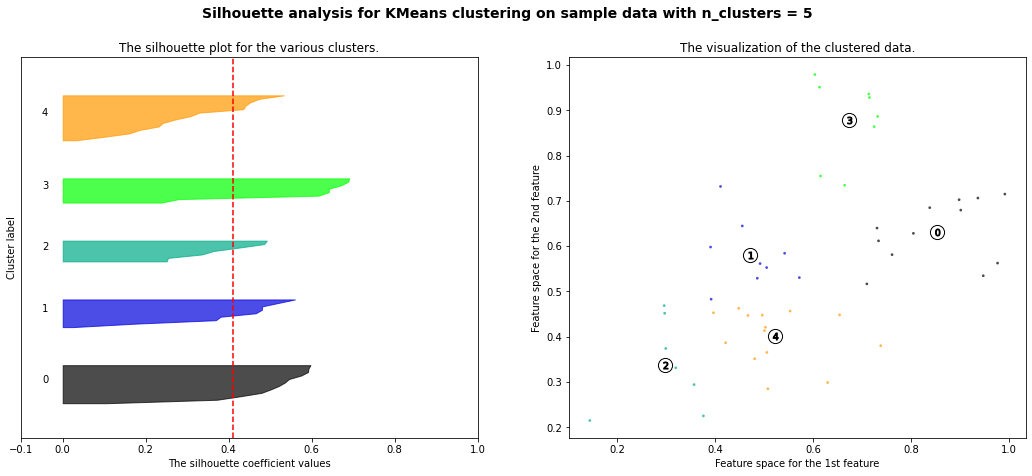

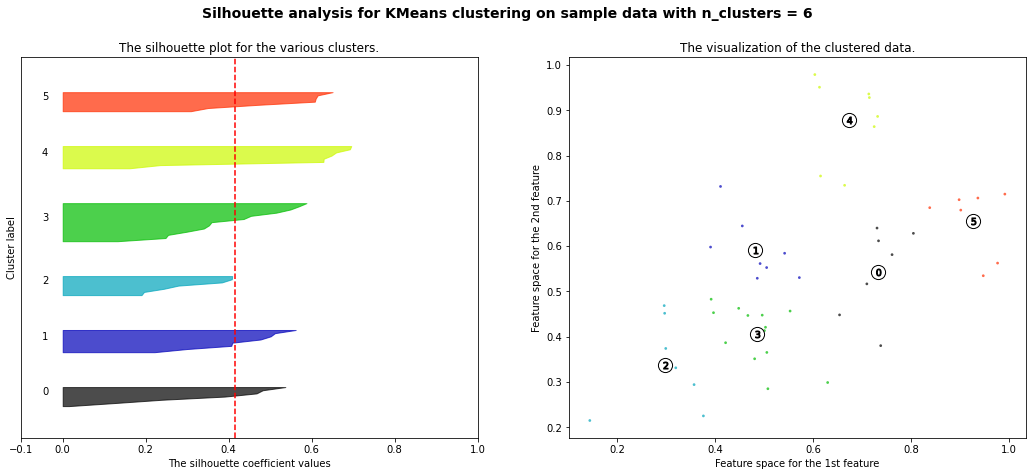

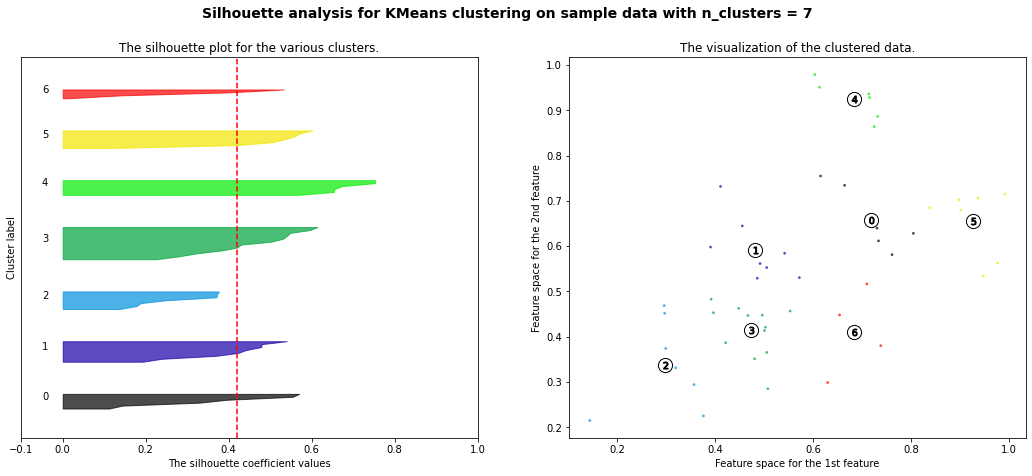

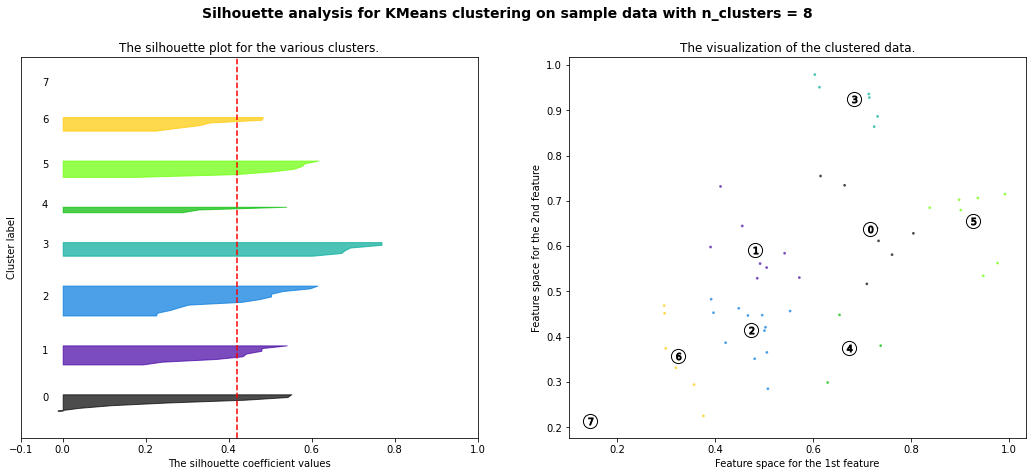

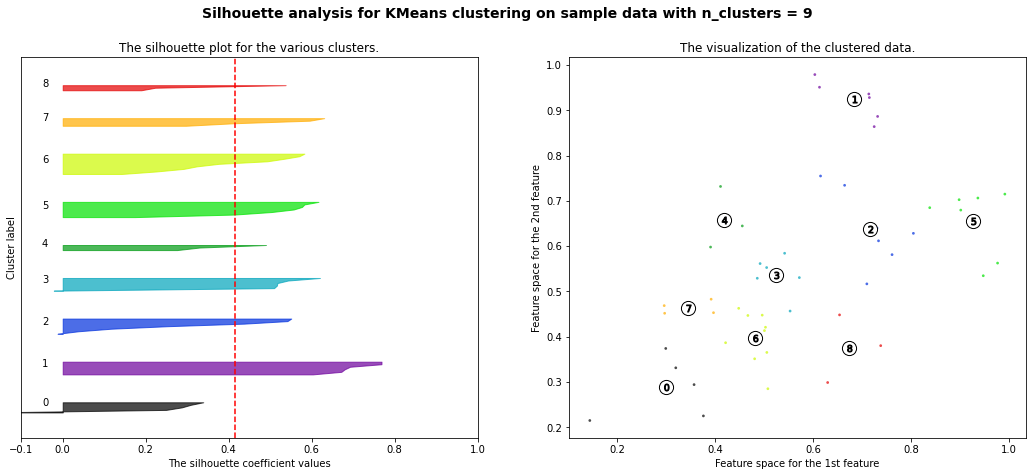

In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
sil_avg_list = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    sil_avg_list.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The silhouette plot shows that the n_clusters value of 4, 6, 7 and 9 are a bad pick for the given data either due to the presence of clusters with below average silhouette scores or due to wide fluctuations in the size of the silhouette plots. 

We can clearly see how the silhouette score peaks up at k=2, which indicates that there are 2 dense agglomerates.

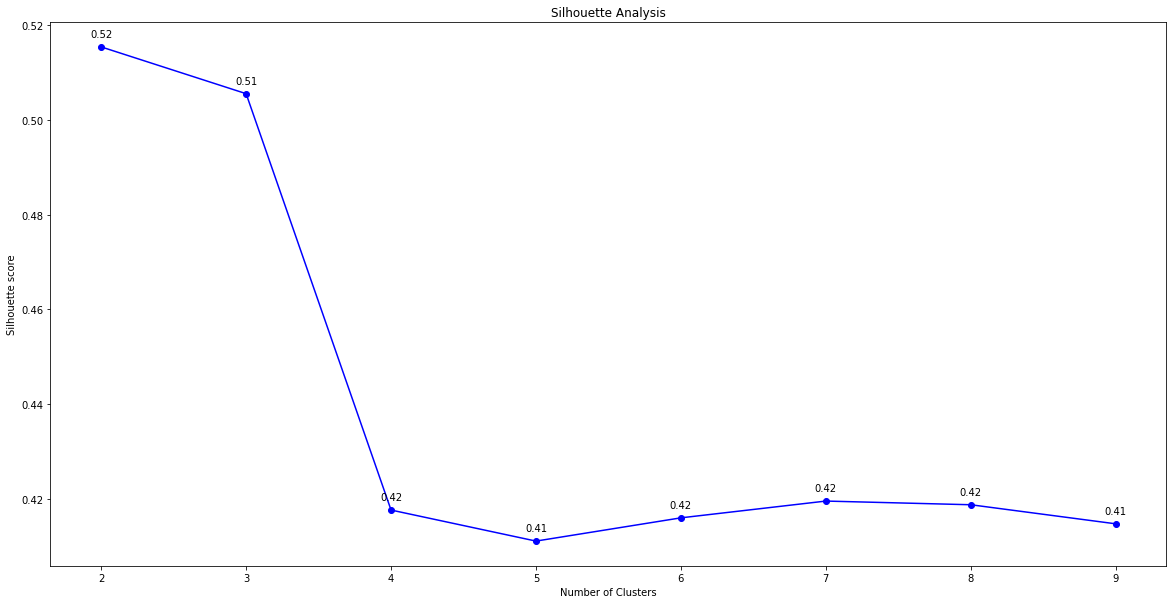

In [41]:
# Create plot
xs, ys = range_n_clusters, sil_avg_list
visualize(xs, ys, ylabel="Silhouette score", title="Silhouette Analysis")

### Finding clusters with K=2
---

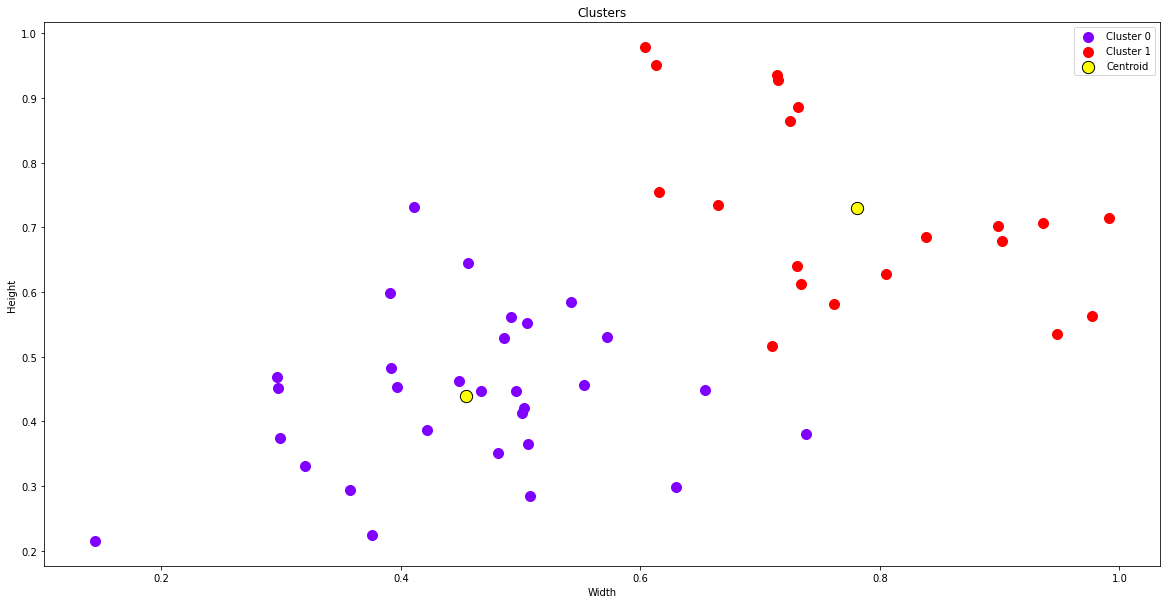

In [47]:
n_clusters=2
y_means, centroids = create_clusters(X, n_clusters)
plot_clusters(X, y_means, centroids, n_clusters)

# Conclusion
---

From the mean IoU vs number of clusters graph and Elbow method graph and silhouette analysis, we can observe that **K=2 is the best number of cluster for this dog dataset which gives mean IoU of 0.71**.

Also, looking at the above 2 cluster graph, 4 clusters seem to be an overfit.

If we observe the log density graph also, we would observe **2 clusters**.

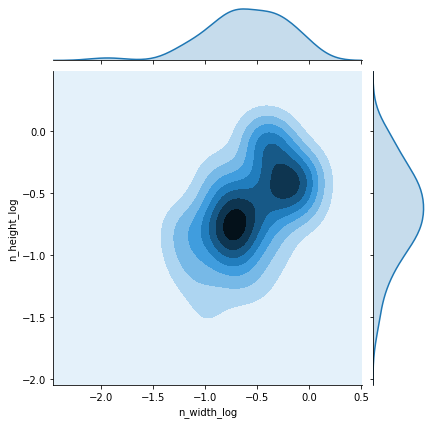

In [49]:
sns.jointplot(x="n_width_log", y="n_height_log", data=dataset, kind='kde')